# First learning attempts
### using Beethoven dataset
* 29 pieces + transpositions across 2 octaves
* ~70h of music (2.7h per transposition)
* 0.025s resolution (40fps)

In [1]:
IGNORE_NOTE_VELOCITY = True
TARGET_IS_SEQUENCE = True
MAX_WINDOW_SIZE = 50

# loading data files names
import os

path = '.\\datasets\\beethoven\\'
file_names = os.listdir(path)
file_names = list(filter(lambda fn: '.npz' in fn or '.npy' in fn or '.csv' in fn, file_names))
assert len(file_names) > 0, 'Data not found'

f'Found {len(file_names)} files'

'Found 29 files'

In [2]:
# loading data files
from midi_numpy.common import read_numpy_midi
file_paths = [f'{path}{fn}' for fn in file_names]

from random import choice
def load_tracks(n):
    print('loading tracks')
    sampled_file_paths = [choice(file_paths) for _ in range(n)]
    tracks = [read_numpy_midi(fp) for fp in sampled_file_paths]
    if IGNORE_NOTE_VELOCITY:
        tracks = [t[:, :128] for t in tracks]
    return tracks

In [14]:
# select batch
def create_batch(data, batch_size, seq_length):
    # each sequence is from diffrent track
    tracks_indices = np.random.randint(0, len(data), batch_size)
    # select sequences from selected tracks
    seq_indicies = [np.random.randint(0, len(data[ti]) - seq_length - 1) 
                    for ti in tracks_indices]
    # transform indices to slices
    x_slice = lambda si: np.s_[si:si + seq_length]
    y_slice = lambda si: (
        np.s_[si + 1:si + seq_length + 1] 
        if TARGET_IS_SEQUENCE 
        else np.s_[si + seq_length]
    )
    x = np.stack([data[ti][x_slice(si)] for ti,si in zip(tracks_indices, seq_indicies)])
    y = np.stack([data[ti][y_slice(si)] for ti,si in zip(tracks_indices, seq_indicies)])
    return x, y

In [4]:
# dataset generator
import numpy as np
def data_gen(batch_size, seq_len, track_count=25):
    # x data shape should be [batch_size, sequence_len, input_dim]
    # y shape is [batch_size, input_dim]  
    while True:
        print('reloading data')
        data = load_tracks(track_count)  
        print(f'reloaded data')
        for _ in range(1000 * len(data)):
            seq = np.random.randint(seq_len[0], seq_len[1])
            yield create_batch(data, batch_size, seq)

## Setting up model

In [5]:
from tensorflow import keras as K

INPUT_SIZE = 128 if IGNORE_NOTE_VELOCITY else 256
HIDDEN_SIZE = 512
OUTPUT_SIZE = INPUT_SIZE

BATCH_SIZE = 16

INPUT_SHAPE = (None, INPUT_SIZE)
# None means that sequence length is not strictly defined
# 3 dim - batch size, is defined implicitly

In [6]:
model = K.models.Sequential([
    K.layers.LSTM(
        HIDDEN_SIZE, 
        input_shape=INPUT_SHAPE, 
        return_sequences=TARGET_IS_SEQUENCE
    ),
    K.layers.Dense(OUTPUT_SIZE, activation='sigmoid')
])

model.compile(
    loss=K.losses.BinaryCrossentropy(), 
    optimizer=K.optimizers.Adam(), 
    metrics=[
        K.metrics.BinaryAccuracy(), 
        K.metrics.FalsePositives(), 
        K.metrics.FalseNegatives()
    ]
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [ ]:
# or load saved model
base_path = ''
file_name = ''
model = K.models.load_model(base_path + file_name)

In [15]:
# pre running operations
# some stat data accumultors for re-running model
from time import time
epochs_elapsed = 0
minutes_elapsed = 0
gen = data_gen(BATCH_SIZE, seq_len=(1, MAX_WINDOW_SIZE), track_count=100)
test_gen = data_gen(BATCH_SIZE, seq_len=(1, MAX_WINDOW_SIZE), track_count=10)

### Running model

Epoch 1/2
1/1 [==============================] - 0s 219ms/step - loss: 0.1117 - binary_accuracy: 0.9751 - false_positives: 0.0000e+00 - false_negatives: 2141.0000
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

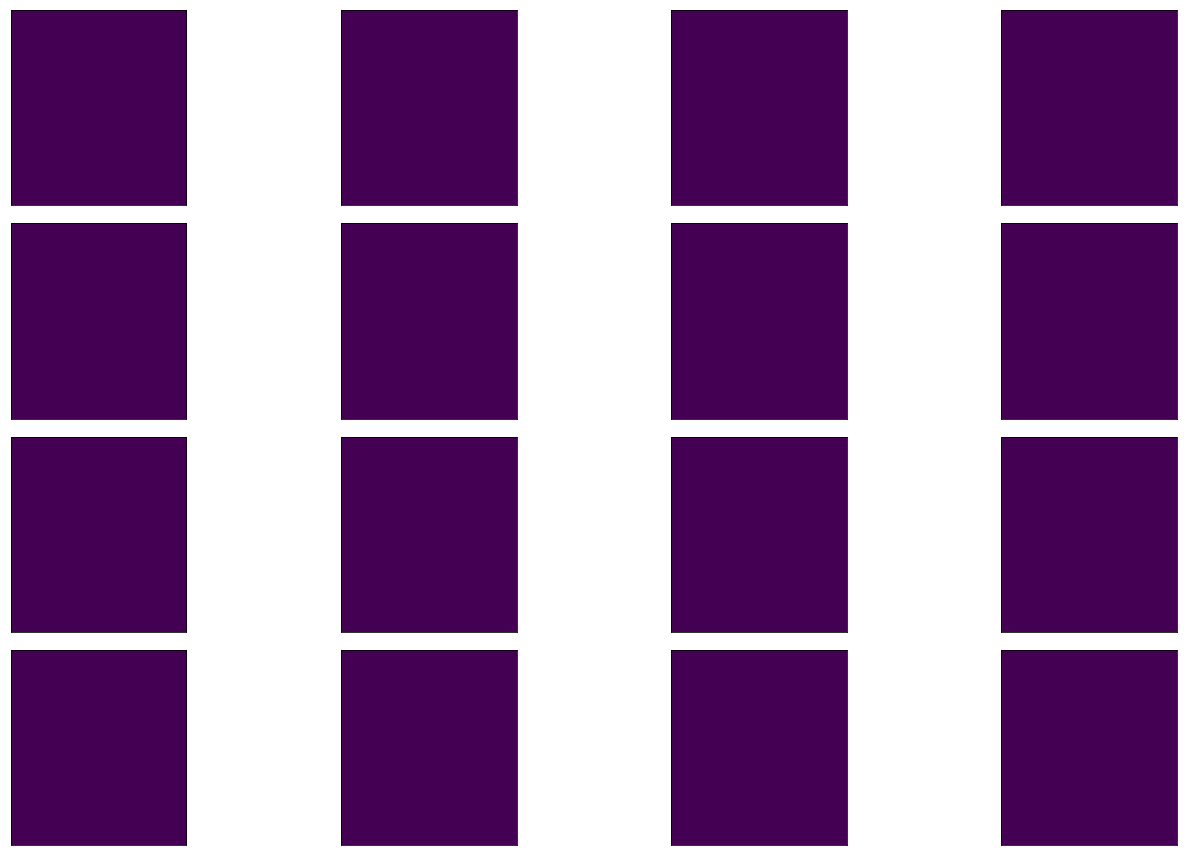

10/10 [==============================] - 32s 3s/step - loss: 0.1561 - binary_accuracy: 0.9777 - false_positives: 0.0000e+00 - false_negatives: 11346.0000 - val_loss: 0.1117 - val_binary_accuracy: 0.9751 - val_false_positives: 0.0000e+00 - val_false_negatives: 2141.0000
Epoch 2/2
1/1 [==============================] - 0s 266ms/step - loss: 0.0993 - binary_accuracy: 0.9801 - false_positives: 0.0000e+00 - false_negatives: 1994.0000
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

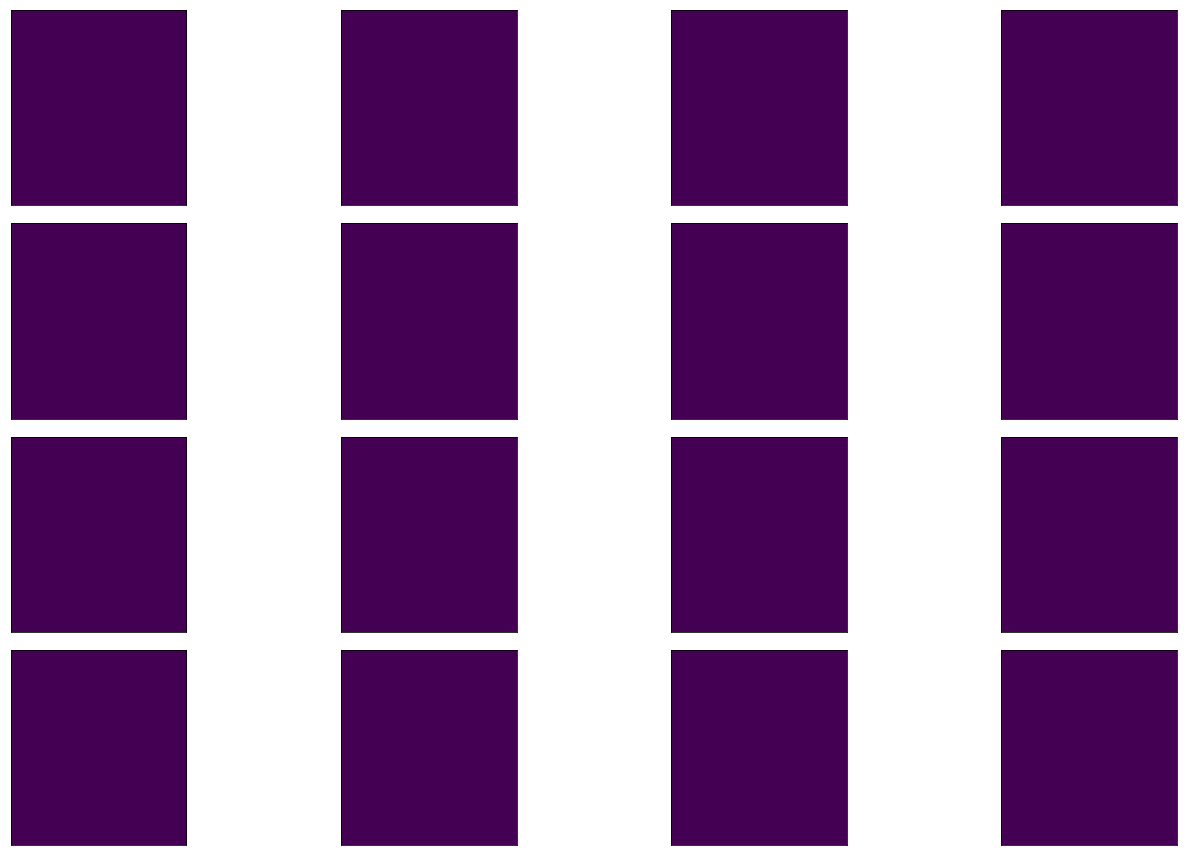

10/10 [==============================] - 31s 3s/step - loss: 0.1383 - binary_accuracy: 0.9795 - false_positives: 0.0000e+00 - false_negatives: 8670.0000 - val_loss: 0.0993 - val_binary_accuracy: 0.9801 - val_false_positives: 0.0000e+00 - val_false_negatives: 1994.0000


In [23]:
EPOCHS = 1
STEPS_PER_EPOCH = 1000
start_time = time()

model.fit_generator(
    gen, 
    steps_per_epoch=STEPS_PER_EPOCH, 
    epochs=EPOCHS, 
    validation_data=test_gen, 
    validation_steps=1,
    callbacks=[CustomCallback(600, 16)]
)

minutes_elapsed += (time() - start_time) // 60
epochs_elapsed += EPOCHS

### testing/plotting

In [18]:
def generate(seq_length, batch_size=1, window_len=MAX_WINDOW_SIZE):
    # sequence shape is [batch_size, sequence_length, input_size]
#     seed = np.zeros((batch_size, 1, INPUT_SIZE)) 
    seed = np.random.random((batch_size, 15, INPUT_SIZE)) * 0.5
    x = seed
    accum = [seed]
    for i in range(seq_length):
        print(i, end=',')
        res = model.predict(x)
        if TARGET_IS_SEQUENCE:
            # next input consists of first old input first frame
            # and whole result sequence
            # (then limited to window size)
#             x = np.concatenate([x[:, 0:1, :], res], axis=1)[:, -MAX_WINDOW_SIZE:, :]
            x = np.concatenate([x, res[:, -1:, :]], axis=1)[:, -MAX_WINDOW_SIZE:, :]
            accum.append(res[:, -1:, :])
        else:
            # next input consists of previous input
            # with result frame attatched to end
            # (then limited to window size)
            x = np.concatenate([x, res[:, np.newaxis, :]], axis=1)[:, -MAX_WINDOW_SIZE:, :]
            accum.append(res[:, np.newaxis, :])
    return np.concatenate(accum, axis=1).round()

In [22]:
import matplotlib.pyplot as plt
def generate_plot(length=300, batch_size=16):
    x = generate(length, batch_size)
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 12),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax, x_ in zip(axs.flat, x):
        ax.imshow(x_.T[::-1, :])
    plt.tight_layout()
    plt.show()

In [21]:
# wrapping it up in callback
class CustomCallback(K.callbacks.Callback):
    def __init__(self, plot_length, batch_size):
        super().__init__()
        self.plot_length = plot_length
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs={}):
        generate_plot(self.plot_length, self.batch_size)
        return

### Saving model

In [ ]:
base_path = ''
keywords = '_'.join(['beth', 'notransp', 'randchunk'])
file_name = f'{keywords}_{HIDDEN_SIZE}_{epochs_elapsed}epochs_{minutes_elapsed}m.h5'

K.models.save_model(model, base_path + file_name)